In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt

from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

import pylab

from IPython.display import display
from IPython.display import Image
import pandas as pd
import numpy as np
import scipy as sp

pd.set_option('display.max_columns', 70)

import sys
import os
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import KFold
from sklearn import metrics
from random import *
import datetime

import xgboost as xgb
from sklearn.cross_validation import LabelShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pickle

from common import *
from prepare_data import *

### Exploratory analysis
#### Reading data

In [2]:
transactions = pd.read_csv('data/transactions.csv', dtype = {'customer_id': 'int32', 'mcc_code': 'int32','tr_type': 'int32'})
mcc_codes = pd.read_csv('data/tr_mcc_codes.csv', sep = ';')
mcc_codes_dict = dict(zip(mcc_codes['mcc_code'], mcc_codes['mcc_description']))

In [3]:
transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [4]:
mcc_codes.head()

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


In [5]:
transactions['day'] = transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype('int16')

In [6]:
[len(transactions), transactions.day.nunique(), transactions.mcc_code.nunique()]

[6849346, 457, 184]

#### Get only negative transactions

In [7]:
train_transactions = transactions[transactions.amount < 0].copy()

In [8]:
[len(train_transactions), train_transactions.day.nunique(), train_transactions.mcc_code.nunique()]

[5541668, 457, 184]

#### Prepare (mcc_code, day) grid

In [9]:
mcc_code_grid = pd.DataFrame(columns=transactions.mcc_code.unique(), 
                          index=sorted(transactions.day.unique()) + list(range(457, 457 + 30)))
mcc_code_grid = mcc_code_grid.unstack().reset_index().dropna(axis=1)
mcc_code_grid.columns = ['mcc_code', 'day']

mcc_code_grid = pd.merge(mcc_code_grid,
                         train_transactions.groupby(['day', 'mcc_code'])[['amount']].sum().reset_index(),
                         how='left')
mcc_code_grid.fillna(0, inplace = True)
mcc_code_grid.loc[mcc_code_grid.day >= 457, 'amount'] = np.NaN
mcc_code_grid['logAmount'] = np.log(-mcc_code_grid['amount'] + 500)

In [10]:
mcc_code_grid.head()

,mcc_code,day,amount,logAmount
0,4814,0,-11098744.26,16.222388
1,4814,1,-7881825.53,15.880134
2,4814,2,-6777480.45,15.729190
3,4814,3,-9277943.73,16.043204
4,4814,4,-9999757.21,16.118121


In [11]:
[len(mcc_code_grid), (457 + 30) * 184]

[89608, 89608]

#### Exploratory plots

In [12]:
sumAm = mcc_code_grid[['day', 'amount']].groupby('day').aggregate(sum).reset_index()
sumAm['logAmount'] = np.log(-sumAm['amount'] + 500)

Summary amount

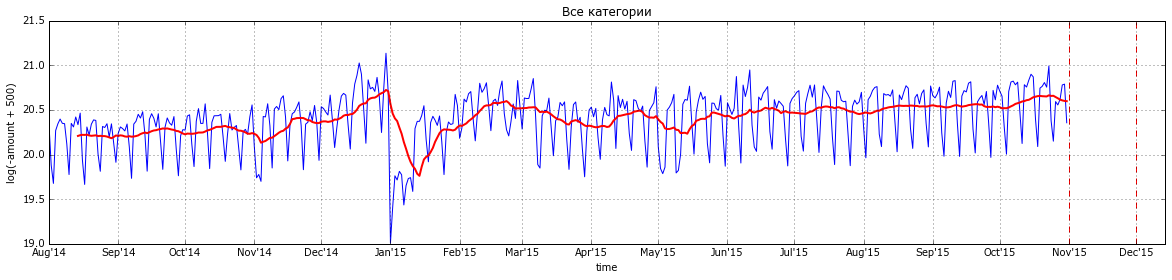

In [13]:
cum_days = np.cumsum([0, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30])
month_names = ['Aug\'14', 'Sep\'14', 'Oct\'14', 'Nov\'14', 'Dec\'14', \
               'Jan\'15', 'Feb\'15', 'Mar\'15', 'Apr\'15', 'May\'15', 'Jun\'15', 'Jul\'15', 'Aug\'15', 'Sep\'15', 'Oct\'15', 'Nov\'15', 'Dec\'15']

plt.rcParams['figure.figsize'] = 20, 4
plt.figure()
x = sumAm.sort_values('day')['day']
y = sumAm.sort_values('day')['logAmount']
plt.plot(x, y)
plt.plot(x, y.rolling(axis=0,window=14,center=False).mean(), 'r', lw=2)
plt.plot([457, 457], [19, 21.5], '--', color = 'r')
plt.plot([487, 487], [19, 21.5], '--', color = 'r')
plt.xticks(cum_days, month_names)
plt.xlabel('time')
plt.ylabel('log(-amount + 500)')
plt.title('Все категории')
plt.grid()
pylab.savefig('png_months/all.png', bbox_inches='tight')
plt.show()

### Date features generating
#### Enrich the grid by date features (weekdays, holidays, ...)

In [14]:
mcc_code_grid = prepareTransactions(mcc_code_grid, startDate)

In [15]:
sumAm = sumAm.merge(mcc_code_grid[['day', 'isHoliday6']].drop_duplicates().reset_index(drop = True))

Summary amount for all months

In [16]:
if not os.path.exists('png_months'):
    os.makedirs('png_months')

for ind in range(15):
    plt.rcParams['figure.figsize'] = 20, 4
    plt.figure()
    y = np.array(sumAm.sort_values('day')['logAmount'][cum_days[ind]:cum_days[ind + 1]])
    isHoliday6 = sumAm.sort_values('day')['isHoliday6'][cum_days[ind]:cum_days[ind + 1]]
    x = np.arange(1, len(y) + 1)
    plt.plot(x, y)
    plt.scatter(x[np.where(isHoliday6 == 0)], y[np.where(isHoliday6 == 0)], color = 'blue')
    plt.scatter(x[np.where(isHoliday6 == 1)], y[np.where(isHoliday6 == 1)], 30, color = 'red')
    plt.xticks(np.arange(1, len(y) + 1))
    plt.xlim([1, len(x)])
    plt.xlabel('time')
    plt.ylabel('log(-amount + 500)')
    plt.title('Все категории, ' + month_names[ind])
    plt.grid()
    pylab.savefig('png_months/' + month_names[ind].replace('\'', '_') + '.png', bbox_inches='tight')
#    plt.show()
    plt.close()    

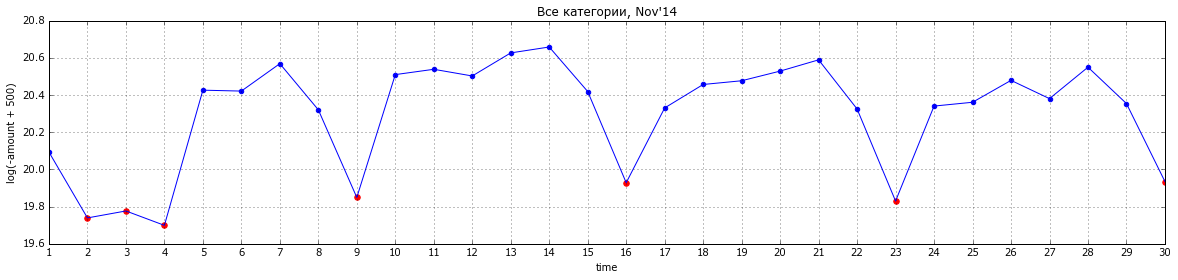

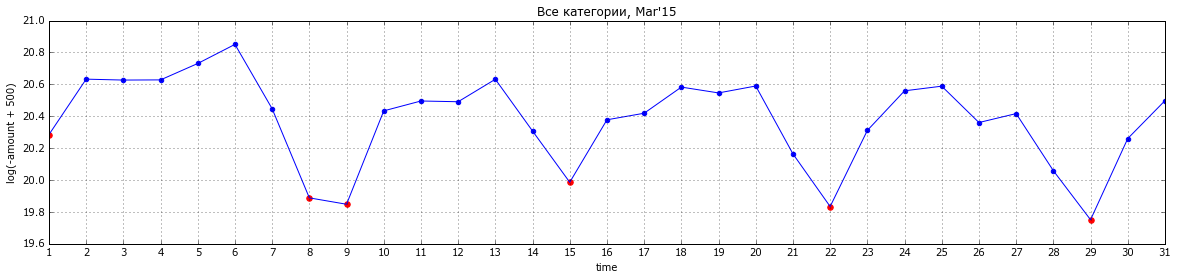

In [17]:
display(Image(filename='png_months/Nov_14.png'))
display(Image(filename='png_months/Mar_15.png'))

Amount for every mcc_code

In [18]:
if not os.path.exists('png_mcc_code'):
    os.makedirs('png_mcc_code')
    
for e in mcc_codes_dict:
    break
    plt.rcParams['figure.figsize'] = 20, 4
    plt.figure()
    x = sorted(mcc_code_grid['day'].value_counts().index)
    y = mcc_code_grid.loc[mcc_code_grid['mcc_code'] == e, ['day', 'logAmount']].sort_values('day')['logAmount']
    plt.plot(x, y)
    plt.plot(x, y.rolling(axis=0,window=14,center=False).mean(), 'r', lw=2)
    plt.plot([457, 457], list(plt.ylim()), '--', color = 'r')
    plt.plot([487, 487], list(plt.ylim()), '--', color = 'r')
    plt.xticks(cum_days, month_names)
    plt.xlabel('time')
    plt.ylabel('log(-amount + 500)')
    title = str(e) + '. ' + mcc_codes_dict[e].replace('/', ',').replace(':', '.')
    plt.title(title)
    plt.grid()
    pylab.savefig('png_mcc_code/' + title + '.png', bbox_inches='tight')
    plt.close()    

In [19]:
def plotMccTimeline(e, vert_ind, fl1 = 0):
    plt.rcParams['figure.figsize'] = 20, 4
    plt.figure()
    x = sorted(mcc_code_grid['day'].value_counts().index)
    y = mcc_code_grid.loc[mcc_code_grid['mcc_code'] == e, ['day', 'logAmount']].sort_values('day')['logAmount']
    
    plt.plot(x, y, lw = 0.5)
    #plt.plot(x, y.rolling(axis=0,window=14,center=False).mean(), 'r', lw=2)
    for i in vert_ind:
        plt.plot([cum_days[i], cum_days[i]], list(plt.ylim()), '--', color = 'r', lw = 2)
        if fl1 == 0:
            if i != 10:
                plt.plot(x[cum_days[i]:cum_days[i+1]], y[cum_days[i]:cum_days[i+1]], 'b', lw = 2)
            else:
                plt.plot(x[cum_days[i]:cum_days[i+1]], y[cum_days[i]:cum_days[i+1]], 'w', lw = 0)
        else:
            if i == 10:
                plt.plot(x[cum_days[i]:cum_days[i+1]], y[cum_days[i]:cum_days[i+1]], 'r', lw = 2)
    #plt.plot([487, 487], list(plt.ylim()), '--', color = 'r')
    plt.xticks(cum_days, month_names)
    plt.xlabel('time')
    plt.ylabel('log(-amount + 500)')
    title = str(e) + '. ' + mcc_codes_dict[e].replace('/', ',').replace(':', '.')
    plt.title(title)
    plt.grid()
    pylab.savefig('png_mcc_code/cv_' + str(fl1) + '_' + title + '.png', bbox_inches='tight')
    plt.show()
    plt.close()

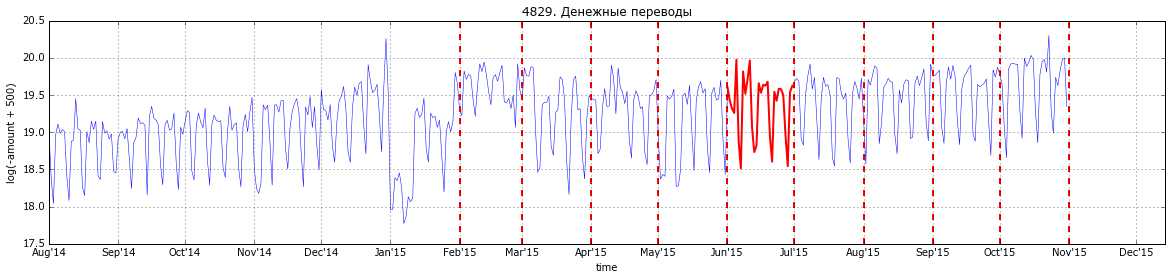

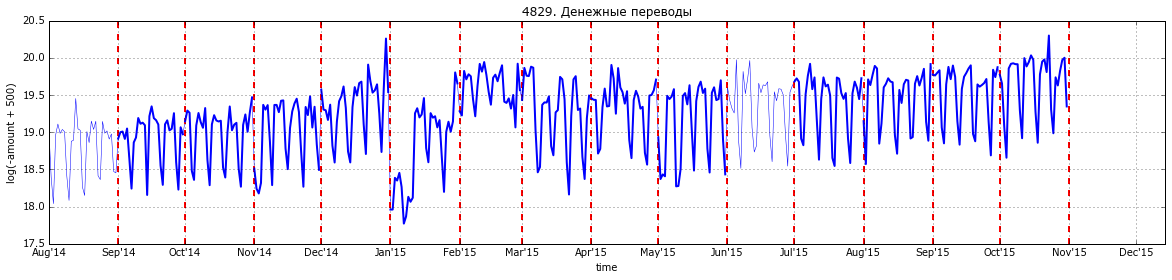

In [20]:
plotMccTimeline(4829, list(range(6, 16)), fl1 = 1)
plotMccTimeline(4829, list(range(1, 16)), fl1 = 0)

### Generate samples with mcc_code features

In [21]:
def makeFeatures(df, columns, functions):
    return df[columns + ['logAmount']].groupby(columns).aggregate(functions).reset_index()

def generateSamplesWithMccCodeFeatures(mcc_code_grid, seed = 0):
    aggColumns = [['mcc_code'], ['mcc_code', 'week_day'], ['mcc_code', 'isWeekend'], ['mcc_code', 'isWeekendHoliday'], ['mcc_code', 'isPredHolidays'], \
                  ['mcc_code', 'isHoliday6'], ['mcc_code', 'isHoliday2']]
    pps = np.array([1, 2, 3, 4, 8, 10, 13, 16, 20, 26, 52, 104]) * 7 #window sizes in days
    
    lags = mcc_code_grid[['day', 'month_day']].drop_duplicates().reset_index().sort_values('day')['month_day']
    nDays = len(lags)
    nCat = len(mcc_code_grid) / nDays
    if seed != 0:
        np.random.seed(seed)
        lags = np.random.randint(30, size = nDays) + 1
    lags[457:] = list(range(1,31)) # use right lags for period for prediction

    agg_names = []
    mcc_code_features = mcc_code_grid.copy()
    for columns in aggColumns:
        for pp in pps:
            print([columns, pp])
            fname = 'logAmount_' + '_'.join(columns[1:]) + '_mean_' + str(pp)
            agg_names.append(fname)
            t = []
            for day in range(nDays):
                lag = lags[day]
                left = min(day - lag - 7, day - pp - 1)
                left = min(left, 457 - 1 - 7) # minimum one-week period
                right = day - lag
                # (left, right] - period for averaging
                ind = ((mcc_code_grid['day'] > left) & (mcc_code_grid['day'] <= right)) & (~mcc_code_grid['logAmount'].isnull())
                #if day % 28 == 0:
                #print([pp, day, np.sum(ind) / nCat], end = ' ')
                if np.sum(ind) > 0:
                    td = makeFeatures(mcc_code_grid[ind], columns, [np.mean])
                    td.columns = columns + [fname]
                    td['day'] = day
                    td['lag'] = lag
                    t.append(td)
    #            break
    #        break
            tm = pd.concat(t)
            mcc_code_features = mcc_code_features.merge(tm, how = 'left')
    #    break
    print()
    mcc_code_features[['mcc_code', 'day', 'lag'] + agg_names].to_csv('data/mcc_code_features_' + str(seed) + '.txt', index = False, float_format='%.5f')    
    return mcc_code_features[['mcc_code', 'day', 'lag'] + agg_names]

In [22]:
for seed in [0, 7, 77, 777]:
    break #uncomment me
    generateSamplesWithMccCodeFeatures(mcc_code_grid, seed = seed)

#### Read saved samples

In [22]:
mcc_code_features_dict = dict()
for seed in [0, 7, 77, 777]:
    mcc_code_features_dict[seed] = pd.read_csv('data/mcc_code_features_' + str(seed) + '.txt')

### Spectral clustering of mcc_codes

In [25]:
from sklearn.cluster import SpectralClustering
import scipy.sparse as sps

def cluster_mcc(transactions):
    mcc_cust = transactions[['mcc_code', 'customer_id']].drop_duplicates()
    customers_id_dict = dict(zip(sorted(mcc_cust.customer_id.unique()), list(range(mcc_cust.customer_id.nunique()))))
    mcc_code_dict = dict(zip(sorted(mcc_cust.mcc_code.unique()), list(range(mcc_cust.mcc_code.nunique()))))

    rows = []; cols = []; data = []
    for e in mcc_cust.itertuples():
        cols.append(customers_id_dict[e.customer_id])
        rows.append(mcc_code_dict[e.mcc_code])
        data.append(1)

    mcc_cust_m = sps.csr_matrix((data, (rows, cols)))    

    mcc_mcc = mcc_cust_m * mcc_cust_m.transpose()
    d = sps.lil_matrix(mcc_mcc.shape)
    d.setdiag(1 / mcc_mcc.diagonal())
    mcc_mcc_sim = d * mcc_mcc.power(2) * d

    ncl = 46
    cl_mcc = SpectralClustering(n_clusters=ncl, affinity='precomputed', random_state=7)
    y_mcc = cl_mcc.fit_predict(mcc_mcc_sim.toarray())
    order = []
    dens = []
    for j in range(ncl):
        dens.append(np.mean(mcc_mcc_sim.toarray()[np.where(y_mcc == j)][:,np.where(y_mcc == j)]))
    for j in np.argsort(-np.array(dens)):
        print([j, dens[j]])
        for i,e in enumerate(sorted(mcc_cust.mcc_code.unique())):
            if y_mcc[i] == j:
                print([e, mcc_codes_dict[e]])
                order.append(i)
        print()
    plt.figure(figsize = (5, 5))
    pylab.pcolor(mcc_mcc_sim[:,order].tocsr()[order,:].toarray())
    plt.xlim([0, 184])
    plt.ylim([0, 184])
    pylab.savefig('png_mcc_code/cluster.png', bbox_inches='tight')
    plt.show()

    mcc_codes_new_dict = dict(zip(sorted(mcc_cust.mcc_code.unique()), y_mcc))
    mcc_codes_new = mcc_codes.copy()
    mcc_codes_new['mcc_code_new'] = mcc_codes_new['mcc_code'].apply(lambda x: mcc_codes_new_dict[x])
    mcc_codes_new.to_csv('data/tr_mcc_codes_new.csv', index = False, encoding='utf-8')
    mcc_codes_new

[45, 1.0]
[7542, 'Автомойки']

[15, 1.0]
[5921, 'Магазины с продажей спиртных напитков на вынос (пиво, вино и ликер)']

[31, 1.0]
[5399, 'Различные товары общего назначения']

[33, 1.0]
[4121, 'Лимузины и такси']

[28, 1.0]
[7523, 'Паркинги и гаражи']

[40, 1.0]
[5943, 'Магазины офисных, школьных принадлежностей, канцтоваров']

[39, 1.0]
[8641, 'Ассоциации — гражданские, социальные и братские']

[41, 1.0]
[4900, 'Коммунальные услуги — электричество, газ, санитария, вода']

[42, 1.0]
[5611, 'Мужская одежда и аксессуары, включая одежду для мальчиков']

[43, 1.0]
[5719, 'Различные специализированные магазины бытовых принадлежностей']

[3, 0.86777493732345701]
[4814, 'Звонки с использованием телефонов, считывающих магнитную ленту']
[4829, 'Денежные переводы']
[5411, 'Бакалейные магазины, супермаркеты']
[6010, 'Финансовые институты — снятие наличности вручную']
[6011, 'Финансовые институты — снятие наличности автоматически']

[16, 0.78838252424295241]
[5812, 'Места общественного питания, ре

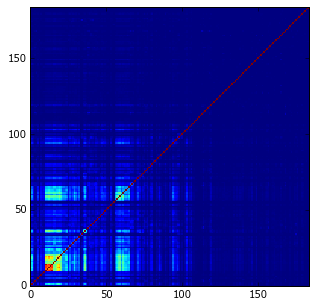

In [26]:
cluster_mcc(transactions)

In [24]:
mcc_codes_new = pd.read_csv('data/tr_mcc_codes_new.csv', sep = ',')
mcc_codes_dict_new = dict(zip(mcc_codes_new['mcc_code'], mcc_codes_new['mcc_code_new']))

### Final features preparation

In [25]:
def prepareFeatures(mcc_code_grid, mcc_code_features, mcc_codes_dict_new):
    features_dict = dict()
    features_dict['date'] = ['day'] + list(mcc_code_grid.columns[4:]) + ['lag']
    
    train = mcc_code_grid.merge(mcc_code_features)
    features_dict['mcc_code'] = list(mcc_code_features.columns[3:])
    
    train['mcc_code_0'] = train['mcc_code']
    train = pd.get_dummies(train, columns=['mcc_code_0'])
    features_dict['mcc_code_dummy'] = ['mcc_code'] + [e for e in list(train.columns) if e.find('mcc_code_0_') != -1]
    
    train['day_0'] = (((train.week_num - 1).astype('int32') * 7 + train.week_day.astype('int32')) + 1)
    train['day_0'] *=  (train.isWeekendHoliday1 | train.isPredHolidays | \
                       ((train.month_num == 2) & (train.month_day == 14)) | ((train.month_num == 9) & (train.month_day == 1)))
    train = pd.get_dummies(train, columns=['day_0'])  
    features_dict['day_dummy'] = [e for e in list(train.columns) if e.find('day_0_') != -1]

    all_mcc = train[['day'] + features_dict['mcc_code']].groupby('day').mean().reset_index()
    features_dict['mcc_code_all'] = [e + '_all' for e in features_dict['mcc_code']]
    all_mcc.columns = ['day'] + features_dict['mcc_code_all']
    train = train.merge(all_mcc)
    
    train['mcc_code_new'] = train['mcc_code'].map(mcc_codes_dict_new)
    train['mcc_code_new_0'] = train['mcc_code_new']
    train = pd.get_dummies(train, columns=['mcc_code_new_0']) 
    features_dict['mcc_code_new_dummy'] = ['mcc_code_new'] + [e for e in list(train.columns) if e.find('mcc_code_new_0_') != -1]

    mcc_new = train[['day', 'mcc_code_new'] + features_dict['mcc_code']].groupby(['day', 'mcc_code_new']).mean().reset_index()
    features_dict['mcc_code_new'] = [e + '_new' for e in features_dict['mcc_code']]
    mcc_new.columns = ['day', 'mcc_code_new'] + [e + '_new' for e in features_dict['mcc_code']]
    train = train.merge(mcc_new)

    for e in train.columns[train.dtypes == 'float64']:
        train[e] = train[e].astype('float32')    

#    display(mcc_new)
    
    return [train, features_dict]

In [26]:
train, features_dict = prepareFeatures(mcc_code_grid[mcc_code_grid.day < 457].copy().reset_index(drop = True), mcc_code_features_dict[0], mcc_codes_dict_new)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84088 entries, 0 to 84087
Columns: 633 entries, mcc_code to logAmount_isHoliday2_mean_728_new
dtypes: float32(613), int32(1), int64(5), int8(14)
memory usage: 201.9 MB
None


In [27]:
print(len(train.columns))
features = []
for e in features_dict:
    features += features_dict[e]
    print([e, len(features_dict[e])])
print([len(features), features])

633
['day_dummy', 128]
['mcc_code_new_dummy', 47]
['mcc_code_new', 84]
['date', 19]
['mcc_code_dummy', 185]
['mcc_code_all', 84]
['mcc_code', 84]
[631, ['day_0_0', 'day_0_3', 'day_0_4', 'day_0_5', 'day_0_6', 'day_0_7', 'day_0_8', 'day_0_9', 'day_0_10', 'day_0_11', 'day_0_12', 'day_0_13', 'day_0_14', 'day_0_20', 'day_0_21', 'day_0_27', 'day_0_28', 'day_0_34', 'day_0_35', 'day_0_41', 'day_0_42', 'day_0_48', 'day_0_49', 'day_0_54', 'day_0_55', 'day_0_56', 'day_0_57', 'day_0_62', 'day_0_63', 'day_0_69', 'day_0_70', 'day_0_71', 'day_0_76', 'day_0_77', 'day_0_83', 'day_0_84', 'day_0_90', 'day_0_91', 'day_0_97', 'day_0_98', 'day_0_104', 'day_0_105', 'day_0_111', 'day_0_112', 'day_0_118', 'day_0_119', 'day_0_123', 'day_0_124', 'day_0_125', 'day_0_126', 'day_0_127', 'day_0_131', 'day_0_132', 'day_0_133', 'day_0_134', 'day_0_139', 'day_0_140', 'day_0_146', 'day_0_147', 'day_0_153', 'day_0_154', 'day_0_160', 'day_0_161', 'day_0_165', 'day_0_166', 'day_0_167', 'day_0_168', 'day_0_174', 'day_0_175'

In [28]:
from sklearn.grid_search import ParameterGrid

def myGS(train, features, param_grid, startMonthTrain_list):
    params = list(ParameterGrid(param_grid))
    res = pd.DataFrame(columns = ['id', 'startMonthTrain'] + list(param_grid.keys()) + ['seed', 'mean'])
    startMonthTest = 14
    j = 0
    for startMonthTrain in startMonthTrain_list:
        for i,param in enumerate(params):
            j += 1
            print(i, end = '')
            param['seed'] = i
            score, _, _, _ = myCV(train, features, param, startMonthTrain, startMonthTest)
            res.loc[j, 'id'] = j
            res.loc[j, 'startMonthTrain'] = startMonthTrain
            for p in param.keys():
                res.loc[j, p] = param[p]
            res.loc[j, 'mean'] = np.mean(score[1])
    return res

In [35]:
def myCV(train, features, xgb_params, startMonthTrain, startMonthTest, flCV = 1):
    train_pred = train[['mcc_code', 'day', 'month_num_1', 'logAmount']].copy()
    train_pred['logAmountPred'] = 0

    score_tr = []
    score_te = []
    models = []
    if flCV == 1:
        for e in range(startMonthTest, 23):
            tr_ind = (train['month_num_1'] != e) & (train['month_num_1'] >= startMonthTrain) 
            te_ind = train['month_num_1'] == e

            model = xgb.XGBRegressor(**xgb_params)
            model.fit(train.loc[tr_ind, features], train.loc[tr_ind, 'logAmount'])
            models.append(model)

            tr_pred = model.predict(train.loc[tr_ind, features])
            te_pred = model.predict(train.loc[te_ind, features])

            score_tr.append(metrics.mean_squared_error(tr_pred, train.loc[tr_ind, 'logAmount'])**0.5)
            score_te.append(metrics.mean_squared_error(te_pred, train.loc[te_ind, 'logAmount'])**0.5)

            train_pred.loc[te_ind, 'logAmountPred'] += te_pred
    
    final_model = xgb.XGBRegressor(**xgb_params)
    tr_ind = (train['month_num_1'] >= startMonthTrain)
    final_model.fit(train.loc[tr_ind, features], train.loc[tr_ind, 'logAmount'])
    
    print([np.mean(score_tr), np.mean(score_te)])
    return [[score_tr, score_te], train_pred, models, final_model]

In [30]:
param_grid = {'max_depth': [3, 4, 5, 6],
              'min_child_weight': [10, 20, 40],
              'n_estimators': [80, 100, 150],
              'learning_rate': [0.1],
              'colsample_bylevel': [0.05, 0.1, 0.2],
             }
startMonthTrain_list = [9, 10, 11, 12, 13, 14]
#resGS = myGS(train, features, param_grid, startMonthTrain_list)
#resGS[resGS.startMonthTrain == 9].sort_values('mean', ascending = True)

In [35]:
xgb_params = {'max_depth': 4, 
              'min_child_weight': 20, 
              'n_estimators': 80,
              'learning_rate': 0.1,
              'colsample_bylevel':  0.1,
              'silent': False,
              'seed': 0}

In [31]:
features1 = features_dict['date'] + features_dict['mcc_code']
features2 = features1 + features_dict['mcc_code_dummy'] + features_dict['day_dummy']
features_list = [features1, features2, features]

In [4]:
'''
df_res = pd.DataFrame(columns = ['featuresGr', 'seed', 'month_num_1', 'mean'])

j = 0
for fi, f in enumerate(features_list):
    for seed in range(5):
        xgb_params_e = xgb_params.copy()
        xgb_params_e['seed'] = seed
        score, train_pred, _, _ = myCV(train, f, xgb_params_e, 9, 14)
        for i in range(len(score[1])):
            j += 1
            df_res.loc[j, 'featuresGr'] = fi
            df_res.loc[j, 'seed'] = seed
            df_res.loc[j, 'month_num_1'] = 14 + i
            df_res.loc[j, 'mean'] = score[1][i]
            print([i, score[0][i], score[1][i]])
        print()
'''

"\ndf_res = pd.DataFrame(columns = ['featuresGr', 'seed', 'month_num_1', 'mean'])\n\nj = 0\nfor fi, f in enumerate(features_list):\n    for seed in range(5):\n        xgb_params_e = xgb_params.copy()\n        xgb_params_e['seed'] = seed\n        score, train_pred, _, _ = myCV(train, f, xgb_params_e, 9, 14)\n        for i in range(len(score[1])):\n            j += 1\n            df_res.loc[j, 'featuresGr'] = fi\n            df_res.loc[j, 'seed'] = seed\n            df_res.loc[j, 'month_num_1'] = 14 + i\n            df_res.loc[j, 'mean'] = score[1][i]\n            print([i, score[0][i], score[1][i]])\n        print()\n"

In [ ]:
'''
df_res['mean'] = df_res['mean'].astype('float')
display(df_res[['featuresGr', 'mean']].groupby('featuresGr').agg(np.mean).reset_index())
display(df_res[['featuresGr', 'month_num_1', 'mean']].groupby(['featuresGr', 'month_num_1']).agg(np.mean).reset_index())

plt.rcParams['figure.figsize'] = 20, 4
plt.figure()
df_res['RMSLE'] = df_res['mean']
df_res.loc[df_res.featuresGr == 2, ['month_num_1', 'RMSLE']].boxplot(by='month_num_1')
plt.xticks(list(range(1, 10)), month_names[6:])
pylab.savefig('png_months/boxplots.png', bbox_inches='tight')
plt.show()
plt.rcParams['figure.figsize'] = 5, 4
plt.figure()
df_res.loc[(df_res.featuresGr == 2) & (df_res.month_num_1 == 22), ['month_num_1', 'RMSLE']].boxplot(by='month_num_1')
plt.xticks([1], ['Oct'])
pylab.savefig('png_months/boxplots_oct.png', bbox_inches='tight')
plt.show()
'''

### Final model

In [32]:
xgb_params_final = {'max_depth': 4, 
                    'min_child_weight': 20, 
                    'n_estimators': 350,
                    'learning_rate': 0.03,
                    'colsample_bylevel':  0.1,
                    'subsample': 0.8,
                    'silent': False,
                    'seed': 0}

In [33]:
final_features = features

In [36]:
j = 0
score_list = []
train_pred_list = []
models_list = []
final_models = []
for seed in [0, 7, 77, 777]:
    print(seed)
    ttrain, _ = prepareFeatures(mcc_code_grid[mcc_code_grid.day < 457].copy().reset_index(drop = True), mcc_code_features_dict[seed], mcc_codes_dict_new)
    for e in range(3):
        j += 1
        print(j, end = ' ')
        xgb_params_e = xgb_params_final.copy()
        xgb_params_e['seed'] = j
        score, train_pred, models, final_model = myCV(ttrain, final_features, xgb_params_e, 9, 14)
        score_list.append(score)
        train_pred_list.append(train_pred)
        models_list.append(models)
        final_models.append(final_model)
        print()

0
1 [1.53322492509179, 1.5502279438259512]

2 [1.5329351228165384, 1.5493875778137094]

3 [1.5334977177788067, 1.5500014434042124]

7
4 [1.5350775600313109, 1.5462266341107429]

5 [1.5351269093912008, 1.5465680740650429]

6 [1.5348860940344897, 1.5460709560497621]

77
7 [1.5342432476870833, 1.5468787247720017]

8 [1.5341025753423319, 1.5467068965609936]

9 [1.534199525386839, 1.5467859116465612]

777
10 [1.5350457335644416, 1.5469891627969297]

11 [1.5349676517717403, 1.5478693457524098]

12 [1.5348698279888835, 1.5470708951763967]



In [37]:
train_pred_final = train[['mcc_code', 'day', 'month_num_1', 'logAmount']].copy()
train_pred_final['logAmountPred'] = 0

for models in models_list:
    for i,e in enumerate(range(14, 23)):
        te_ind = train['month_num_1'] == e
        te_pred = models[i].predict(train.loc[te_ind, final_features])
        train_pred_final.loc[te_ind, 'logAmountPred'] += te_pred
train_pred_final['logAmountPred'] /= len(models_list)

In [38]:
score_final = []
for e in range(14, 23):
    ind_e = train_pred_final.month_num_1 == e
    score_final.append(metrics.mean_squared_error(train_pred_final.loc[ind_e, 'logAmountPred'], train_pred_final.loc[ind_e, 'logAmount'])**0.5)
    print([e, score_final[-1]])
np.mean(score_final)

[14, 1.5344773002412235]
[15, 1.5482506518749541]
[16, 1.5314972271201681]
[17, 1.5273642401856813]
[18, 1.5351966577718801]
[19, 1.5731383226538043]
[20, 1.5957153411064549]
[21, 1.5616576721106663]
[22, 1.5269003148713378]


1.548244191992908

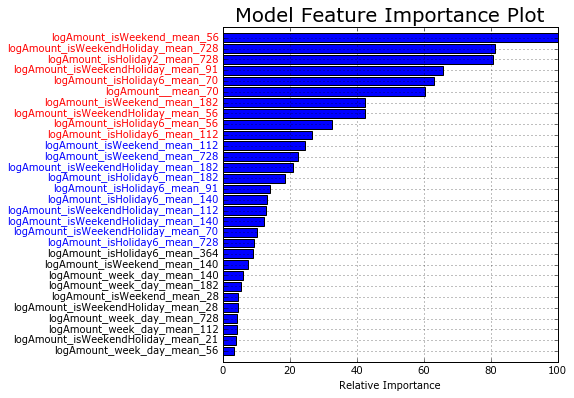

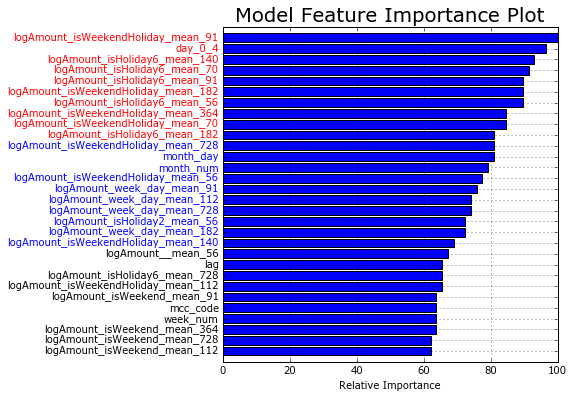

In [43]:
modelInd = 1
drawFeaturesImportancePlot(getFeaturesImportance1(final_models[modelInd]._Booster.feature_names, final_models[modelInd], importance_type='gain'), 30)
drawFeaturesImportancePlot(getFeaturesImportance1(final_models[modelInd]._Booster.feature_names, final_models[modelInd], importance_type='weight'), 30)

In [44]:
test, _ = prepareFeatures(mcc_code_grid[mcc_code_grid.day >= 457].copy().reset_index(drop = True), mcc_code_features_dict[0], mcc_codes_dict_new)
for ee in final_features:
    if not (ee in test.columns):
        test[ee] = 0
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5520 entries, 0 to 5519
Columns: 634 entries, mcc_code to day_0_364
dtypes: float32(497), int32(1), int64(122), int8(14)
memory usage: 15.7 MB
None


In [45]:
test['logAmountPred'] = 0
for i,_ in enumerate(final_models):
    test['logAmountPred'] += (final_models[i].predict(test[final_features]))
test['logAmountPred'] /= len(final_models)

In [53]:
#test.loc[test.mcc_code == 4829, ['mcc_code', 'day', 'logAmountPred']]

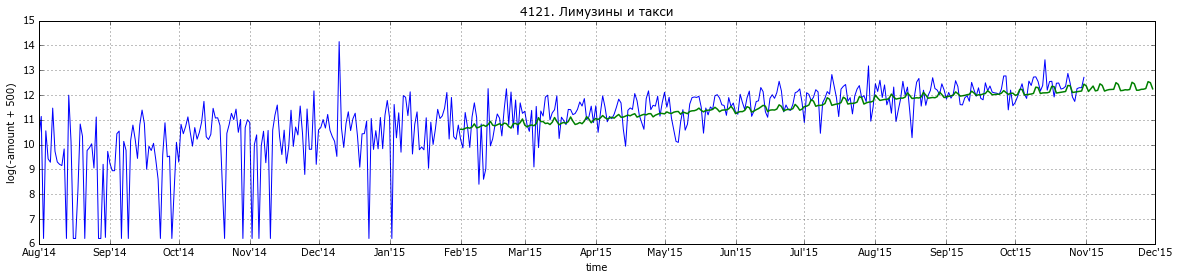

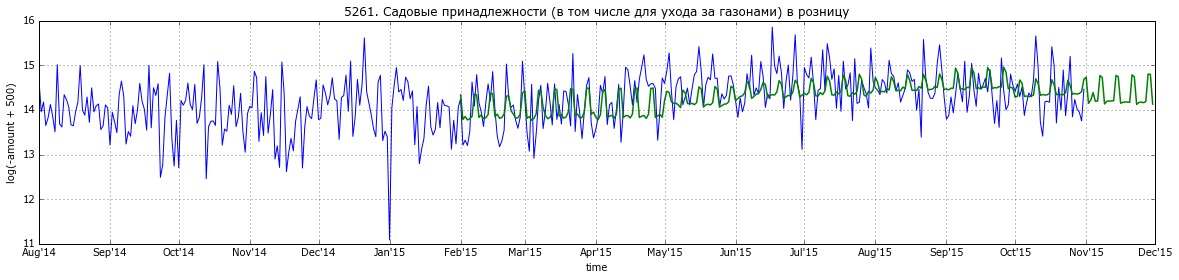

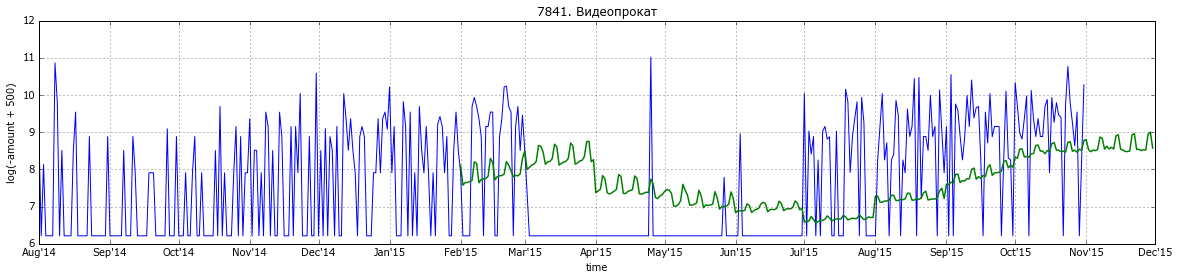

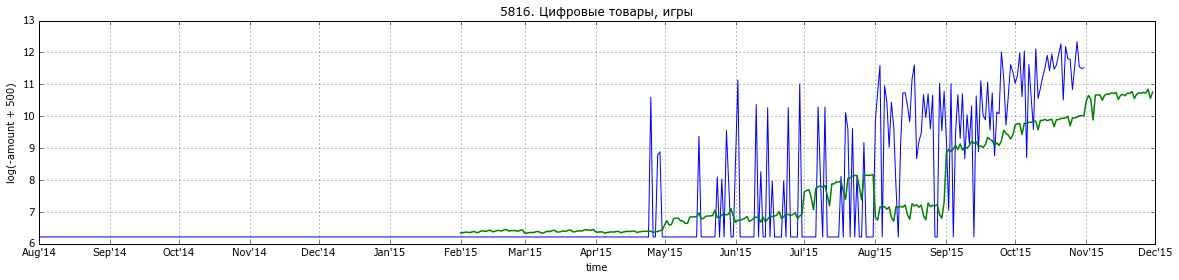

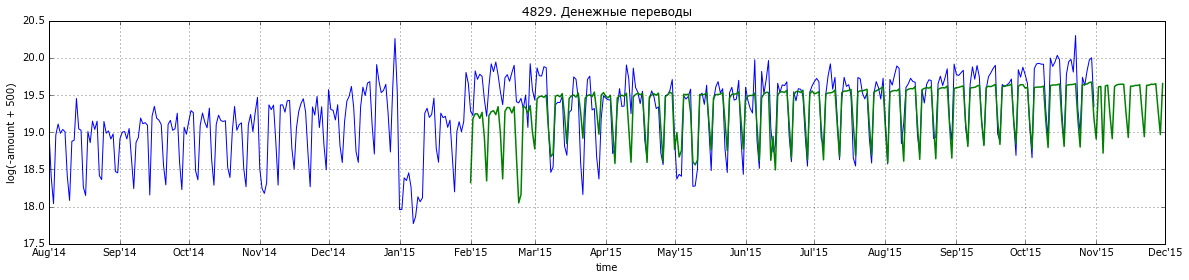

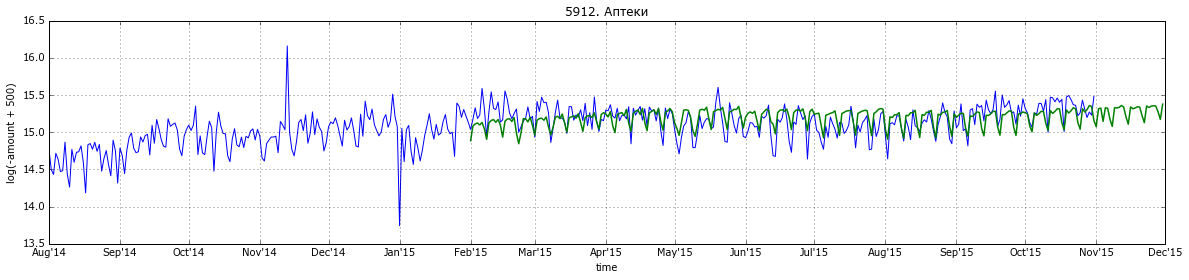

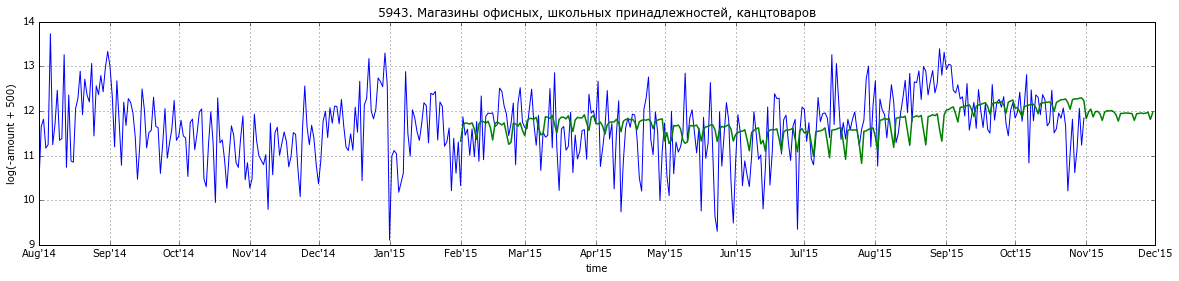

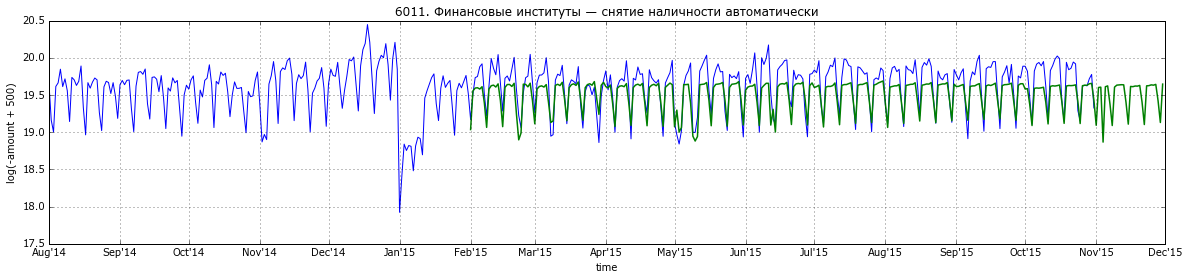

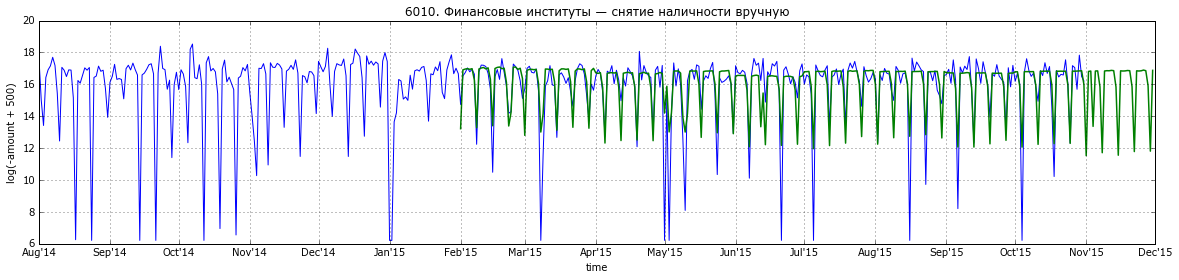

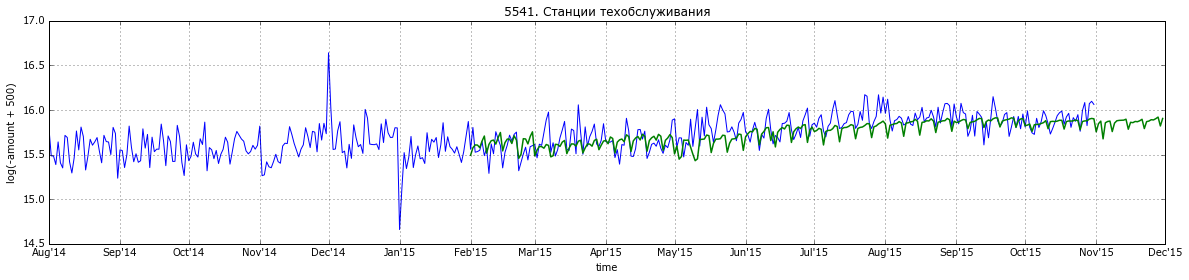

In [59]:
startInd = 6

mcc_code_show_list = [4829, 4121, 5816, 7841, 5912, 6010, 6011, 5261,  5943, 5541]

if not os.path.exists('png_mcc_code_pred'):
    os.makedirs('png_mcc_code_pred')
    
x = sorted(list(set(train['day'])))
xp = sorted(list(set(test['day'])))

#for mcc_code in mcc_code_show_list:
for i,mcc_code in enumerate(mcc_codes_dict):
#    break
    plt.rcParams['figure.figsize'] = 20, 4
    plt.figure()

    y1 = train.loc[train['mcc_code'] == mcc_code, ['day', 'logAmount']].sort_values('day')['logAmount']
    plt.plot(x, y1)
#    plt.plot(x, y1.rolling(axis=0,window=14,center=False).mean(), 'r', lw=1)

    yp1 = list(train_pred_final[train_pred_final['mcc_code'] == mcc_code].sort_values('day')['logAmountPred'])
    yp2 = list(test[test['mcc_code'] == mcc_code].sort_values('day')['logAmountPred'])
    plt.plot(x[cum_days[startInd]:] + list(range(457, 457 + 30)), yp1[cum_days[startInd]:] + yp2, lw=1.5)

    title = str(mcc_code) + '. ' + mcc_codes_dict[mcc_code].replace('/', ',').replace(':', '.')
    plt.title(title)
    plt.xticks(cum_days, month_names)
    plt.xlabel('time')
    plt.ylabel('log(-amount + 500)')
    plt.xlim([0, 487])
    plt.grid()
    pylab.savefig('png_mcc_code_pred/' + title[:80] + '.png', bbox_inches='tight')
    if mcc_code in mcc_code_show_list:
        plt.show()
    else:
        plt.close()
#    break

In [49]:
'''
plt.rcParams['figure.figsize'] = 20, 5

for mcc_code in sorted(mcc_codes_dict.keys()):
    plt.rcParams['figure.figsize'] = 20, 5

    print(str(mcc_code) + '. ' + mcc_codes_dict[mcc_code])

    y1 = train.loc[train['mcc_code'] == mcc_code, ['day', 'logAmount']].sort_values('day')['logAmount']
    plt.plot(x, y1)

#    plt.plot(x, y1.rolling(axis=0,window=14,center=False).mean(), 'r', lw=1)

    yp1 = list(train_pred_final[train_pred_final['mcc_code'] == mcc_code].sort_values('day')['logAmountPred'])
    yp2 = list(test[test['mcc_code'] == mcc_code].sort_values('day')['logAmountPred'])
    plt.plot(x[cum_days[startInd]:] + list(range(457, 457 + 30)), yp1[cum_days[startInd]:] + yp2, lw=1.5)

    plt.xticks(cum_days, month_names)
    plt.xlim([0, 487])
    plt.grid()
    plt.show()

    plt.rcParams['figure.figsize'] = 20, 2
    plt.plot(x, y1)
    plt.plot(x[cum_days[startInd]:], (y1[cum_days[startInd]:] - yp1[cum_days[startInd]:]))
    plt.xticks(cum_days, month_names) 
    plt.ylim([np.min(y1[cum_days[startInd]:] - yp1[cum_days[startInd]:]), np.max(y1[cum_days[startInd]:] - yp1[cum_days[startInd]:])])
    plt.plot([0, 487], [0, 0], '--', color = 'b')
    plt.grid()
    plt.show()
#    break
'''

"\nplt.rcParams['figure.figsize'] = 20, 5\n\nfor mcc_code in sorted(mcc_codes_dict.keys()):\n    plt.rcParams['figure.figsize'] = 20, 5\n\n    print(str(mcc_code) + '. ' + mcc_codes_dict[mcc_code])\n\n    y1 = train.loc[train['mcc_code'] == mcc_code, ['day', 'logAmount']].sort_values('day')['logAmount']\n    plt.plot(x, y1)\n\n#    plt.plot(x, y1.rolling(axis=0,window=14,center=False).mean(), 'r', lw=1)\n\n    yp1 = list(train_pred_final[train_pred_final['mcc_code'] == mcc_code].sort_values('day')['logAmountPred'])\n    yp2 = list(test[test['mcc_code'] == mcc_code].sort_values('day')['logAmountPred'])\n    plt.plot(x[cum_days[startInd]:] + list(range(457, 457 + 30)), yp1[cum_days[startInd]:] + yp2, lw=1.5)\n\n    plt.xticks(cum_days, month_names)\n    plt.xlim([0, 487])\n    plt.grid()\n    plt.show()\n\n    plt.rcParams['figure.figsize'] = 20, 2\n    plt.plot(x, y1)\n    plt.plot(x[cum_days[startInd]:], (y1[cum_days[startInd]:] - yp1[cum_days[startInd]:]))\n    plt.xticks(cum_days, mo

### Error by mcc_code and day

In [50]:
resError =  []
for e in mcc_codes_dict:
    mcc_code = e
    y1 = train.loc[train['mcc_code'] == mcc_code, ['day', 'logAmount']].sort_values('day')['logAmount']
    yp1 = train_pred[train_pred['mcc_code'] == mcc_code].sort_values('day')['logAmountPred']
    resError.append([e, mcc_codes_dict[e], metrics.mean_squared_error(yp1[184:], y1[184:])**0.5, abs(np.mean(yp1[184:] - y1[184:]))])

In [51]:
sorted(resError, key = lambda x: -x[2])

[[3501,
  'Жилье — отели, мотели, курорты',
  3.159902346112613,
  0.10210464812897063],
 [5681,
  'Изготовление и продажа меховых изделий',
  3.1339786726351941,
  0.22563926990215594],
 [5532, 'Автошины', 2.6787411862473953, 0.28907406111776612],
 [5045,
  'Компьютеры, периферийное компьютерное оборудование, программное обеспечение',
  2.579044973474125,
  0.30298400711227247],
 [8299, 'Образовательные услуги', 2.5734660915867722, 0.032548825819413742],
 [7512, 'Прокат автомобилей', 2.5583836032855203, 0.069135365468678461],
 [5713, 'Покрытия для пола', 2.5478316632076967, 0.089132150014241532],
 [5940,
  'Веломагазины — продажа и обслуживание',
  2.5380102643707803,
  0.3404020215128804],
 [4215,
  'Услуги курьера — по воздуху и на земле, агентство по отправке грузов',
  2.5175418321164478,
  0.28367983639895261],
 [5309,
  'Беспошлинные магазины Duty Free',
  2.5140562909979565,
  0.016585187597589177],
 [8062, 'Больницы', 2.4768963997135982, 0.054608902215084312],
 [8071,
  'Зубны

In [52]:
resErrorDay =  []
for day in range(184, 457):
    y1 = train.loc[train['day'] == day, ['mcc_code', 'logAmount']].sort_values('mcc_code')['logAmount']
    yp1 = train_pred[train_pred['day'] == day].sort_values('mcc_code')['logAmountPred']
    resErrorDay.append([day, startDate + datetime.timedelta(days=day), metrics.mean_squared_error(yp1, y1)**0.5, abs(np.mean(yp1 - y1))])

In [53]:
sorted(resErrorDay, key = lambda x: -x[2])

[[203,
  datetime.datetime(2015, 2, 20, 0, 0),
  1.8535836728552724,
  0.27512729945390119],
 [385,
  datetime.datetime(2015, 8, 21, 0, 0),
  1.8485492865777342,
  0.20398313066233759],
 [192,
  datetime.datetime(2015, 2, 9, 0, 0),
  1.8171736705196622,
  0.19862124453420224],
 [375,
  datetime.datetime(2015, 8, 11, 0, 0),
  1.7863327700889724,
  0.13485488943431689],
 [380,
  datetime.datetime(2015, 8, 16, 0, 0),
  1.7828962028879096,
  0.23157427103623099],
 [185,
  datetime.datetime(2015, 2, 2, 0, 0),
  1.7685577456616324,
  0.021776030892911163],
 [337,
  datetime.datetime(2015, 7, 4, 0, 0),
  1.760619928067066,
  0.12524549079977948],
 [281,
  datetime.datetime(2015, 5, 9, 0, 0),
  1.7603543244326003,
  0.34505599996317987],
 [216,
  datetime.datetime(2015, 3, 5, 0, 0),
  1.7598454751892028,
  0.38518687693969061],
 [401,
  datetime.datetime(2015, 9, 6, 0, 0),
  1.7567725505385734,
  0.10496222972869873],
 [204,
  datetime.datetime(2015, 2, 21, 0, 0),
  1.7433364831700897,
  0.097

### Create submission

In [54]:
result = test[['mcc_code', 'day', 'logAmountPred']].copy()
result['volume'] = np.e ** result['logAmountPred'] - 500

In [55]:
result[['mcc_code', 'day', 'volume']].sort_values(['mcc_code', 'day']).to_csv('submission.csv', index=False)